<a href="https://colab.research.google.com/github/milanfx/DTSA-5511/blob/main/NLP_Disaster_Tweets_Kaggle_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="font-family:Roboto Condensed SemiBold; font-size:150%; letter-spacing: 0px; background-color:darkgreen; color:#f8f2e4; text-align:center; padding-top:10px; padding-bottom:10px; border: 5px solid #f8f2e4; border-radius: 20px;"><h1><b>
NLP Disaster Tweets Kaggle Mini-Project
</b></h1></div>

---

<div style="text-align:center">
<img src="https://github.com/milanfx/Dataset/blob/main/images/nlp_logo.png?raw=true" style="width:850px; height:200px;">
</div>


<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **1. Project Introduction**

</div>

---

### **1.1 Project understanding**

**Background:**

- This Kaggle competition focuses on enhancing emergency response efforts by developing a machine learning model that can accurately identify tweets about real disasters.

- The real-time nature of Twitter makes it a vital tool for disaster relief organizations and news agencies to monitor and respond to emergencies.


**Objective:**

- This project employs Long Short-Term Memory (LSTM) networks to effectively distinguish between tweets that refer to actual disasters and those that do not.

- The final model aims to achieve at least 80% score in classifying disaster-related tweets while maintaining reasonable computational efficiency.

- Evaluating the final model's performance will highlight key areas for further improvements, guiding future enhancements in NLP disaster detection.


**Chanllenge:**

- Tweets often use ambiguous language and metaphors, making accurate interpretation challenging for models.

- The same words and sentences can have different meanings in different contexts.

- High dimensionality and sparsity in text data make models prone to overfitting, memorizing specific patterns instead of learning general features.

---

### **1.2 Data Understanding**

**Data Description**

- The dataset comprises 10k tweets, with 7.6k for training and 3.2k for testing, and each tweet contains a few to about 100 words.

**Evaluation Method**

- The model is evaluated using the F1 score, which measures both precision and recall.

- The optimal solution would achieve an F1 score of 1, indicating perfect classification without any false positives or false negatives.


---

### **1.3 Data Loading**

**Load Library:**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import os
import warnings
import requests
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D, Input, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Load Data from Kaggle:**

In [2]:
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!kaggle competitions download -c nlp-getting-started
!unzip -q nlp-getting-started -d dataset

100% 593k/593k [00:00<00:00, 775kB/s]
100% 593k/593k [00:00<00:00, 774kB/s]


**Check Data Size:**

In [4]:
train_path = '/content/dataset/train.csv'
test_path = '/content/dataset/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f'Train Data Size: {train.shape}')
print(f'Test Data Size: {test.shape}')

Train Data Size: (7613, 5)
Test Data Size: (3263, 4)


**Preview Train and Test Data**

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


- The train and test datasets have been loaded for further preprocessing and analysis.

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **2. Exploratory Analysis**

</div>

---

### **2.1 Sample Distribution**

**Check the Proportion of Negative and Positive samples:**

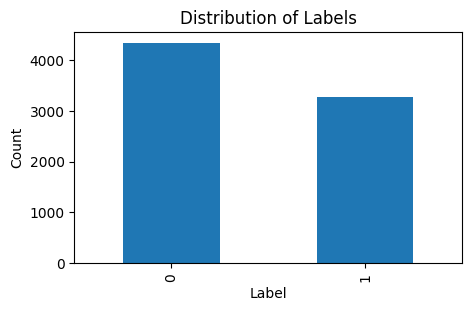

In [7]:
plt.figure(figsize=(5, 3))
train['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

- The ratio of positive to negative samples stands at 3:4; thus, rebalancing may be considered, though it is not required.

---

### **2.2 Sample Comparison**

**Word Cloud:**

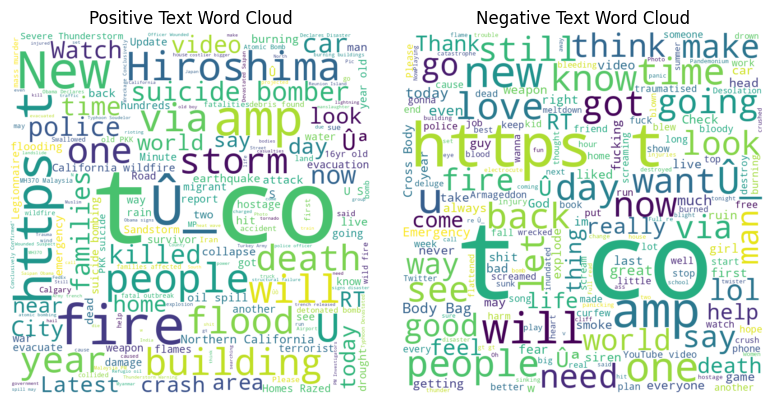

In [9]:
positive_text = ' '.join(train[train['target'] == 1]['text'])
negative_text = ' '.join(train[train['target'] == 0]['text'])

positive_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(negative_text)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Text Word Cloud', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Text Word Cloud', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

- The popular words in positive and negative samples are almost the same, indicating that further cleaning is necessary.

---

### **2.3 Further Cleaning**

**Cleaning Process:**

- Replace &amp with &

- Remove URLs

- Remove HTML tags

- Remove punctuations

- Remove numbers

- Remove non-ASCII characters

- Convert to lowercase

- Remove stopwords and lemmatize

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = set(["u", "im", "one", "new", "like", "get", "know", "go", "day", "time", "make", "people"])

stop_words = stop_words.union(custom_stop_words)

def clean_text(text):
    # Replace &amp; with &
    text = text.replace('&amp;', '&')
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

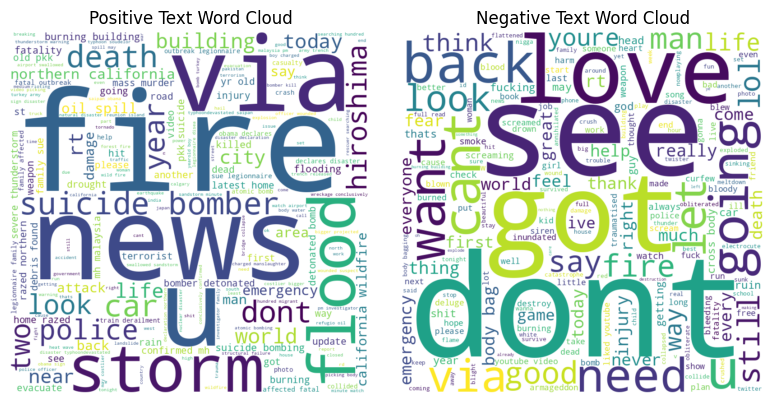

In [11]:
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

positive_text = ' '.join(train[train['target'] == 1]['clean_text'])
negative_text = ' '.join(train[train['target'] == 0]['clean_text'])

positive_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(negative_text)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Text Word Cloud', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Text Word Cloud', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

- After further cleaning, we can see obvious difference in positive and negative samples.

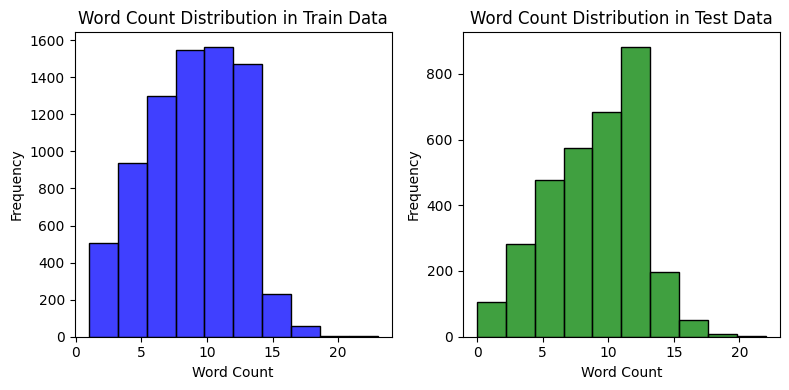

In [12]:
train['word_count'] = train['clean_text'].apply(lambda x: len(x.split()))
test['word_count'] = test['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.histplot(train['word_count'], bins=10, kde=False, color='blue')
plt.title('Word Count Distribution in Train Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test['word_count'], bins=10, kde=False, color='green')
plt.title('Word Count Distribution in Test Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Due to Twitter's limitations, most tweets contain fewer than 20 words.

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **3. Model Architecture**

</div>

---

### **3.1 Split Train and Validation**

**Split into 80% and 20%:**

In [13]:
train_set, val_set = train_test_split(train, test_size=0.2, random_state=1)
X_train = train_set['clean_text']
y_train = train_set['target']

X_val = val_set['clean_text']
y_val = val_set['target']
X_test = test['clean_text']

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_train[1])

(6090,)
(1523,)
(3263,)
forest fire near la ronge sask canada


- We split the data into training, validation, and test sets, then extracted the 'clean_text' for model training and evaluation.

---

### **3.2 tokenizer with xgboost**

**tokenizer Vectorization:**

- Tokenizer vectorization converts text data into numerical representations suitable for machine learning models.

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
len(word_index)

13419

- There are a total of 13,419 unique words in the training data.

In [15]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 20
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)
print(X_train_pad[1])

(6090, 20)
(1523, 20)
(3263, 20)
[5109  525  163   13 2645 5110  834   70    0    0    0    0    0    0
    0    0    0    0    0    0]


- We converted each text into a padded sequence of 20-dimensional vectors.

**tokenizer with xgboost:**

In [16]:
xgb_token = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

xgb_token.fit(X_train_pad, y_train)

y_val_pred = xgb_token.predict(X_val_pad)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       882
           1       0.63      0.55      0.58       641

    accuracy                           0.67      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.67      0.67      1523



- The F1 score on the validation set is 0.67.

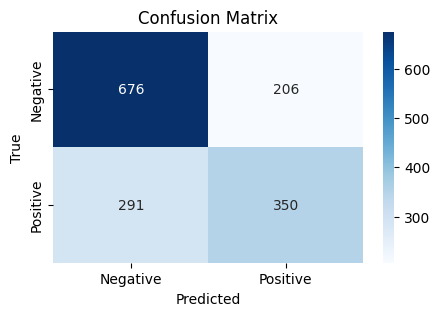

In [17]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
predictions = xgb_token.predict(X_test_pad)
result = pd.DataFrame({
    "id": test['id'],
    "target": predictions
})
result.to_csv('xgb_token.csv', index=False)

- LB result is 0.665
- The poor performance is because the tokenizer only converted the text into sequences of integers, losing contextual information and semantic nuances.

---

### **3.3 TF-IDF with xgboost**

**TF-IDF Vectorization:**

- TF-IDF vectorization transforms text data into numerical representations by measuring the importance of words relative to their frequency in a document and across a collection of documents.

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)
print(X_train_tfidf[1])

(6090, 10000)
(1523, 10000)
(3263, 10000)
  (0, 9877)	0.34854640830425215
  (0, 1550)	0.437069470812259
  (0, 928)	0.5195211506822867
  (0, 2790)	0.3267006348808403
  (0, 6164)	0.3743445979900242
  (0, 9211)	0.41317825458268387


- Each text is transformed into a sparse vector of 10,000 dimensions using TF-IDF vectorization.

In [20]:
xgb_tfidf = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_tfidf.fit(X_train_tfidf, y_train)
y_val_pred = xgb_tfidf.predict(X_val_tfidf)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       882
           1       0.80      0.63      0.70       641

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.78      0.78      0.77      1523



- The F1 score on the validation set is 0.77.

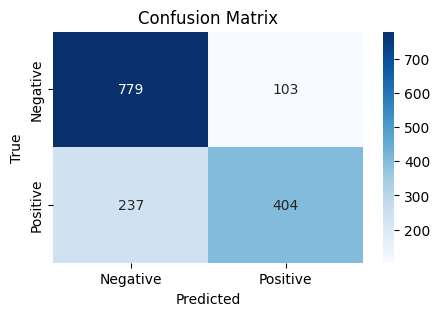

In [21]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
predictions = xgb_tfidf.predict(X_test_tfidf)
result = pd.DataFrame({
    "id": test['id'],
    "target": predictions
})
result.to_csv('xgb_tfidf.csv', index=False)

- LB result is 0.775

- The higher score with TF-IDF is because it captures the importance of words more effectively by considering their frequency both within documents and across the dataset, providing better contextual representation.

- However, TF-IDF has limitations in capturing complex semantic relationships and contextual nuances within the text.

### **3.3 GloVe with LSTM**

**GloVe:**

- GloVe (Global Vectors for Word Representation) is a pre-trained word embedding technique that converts text data into dense vector representations by capturing semantic relationships between words based on their co-occurrence statistics in a large corpus.

In [23]:
local_path = '/content/glove.6B.100d.txt'

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings(local_path)

- We chose the glove.6B.100d model, which contains pre-trained GloVe word vectors with 100-dimensional embeddings, trained on a dataset of 6 billion tokens. These embeddings capture semantic meanings and relationships between words, enabling more effective text representation for various natural language processing tasks.

In [24]:
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**LSTM**

- LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is designed to model sequential data by capturing long-term dependencies and addressing the vanishing gradient problem, making it suitable for tasks such as text classification, language modeling, and time series prediction.

- We build a classic LSTM model with two LSTM layers, each followed by a dropout layer to prevent overfitting. The model also includes two dense layers, with the final dense layer using a sigmoid activation function for binary classification.

In [25]:
LSTM_model = Sequential(name='LSTM_model')
LSTM_model.add(Embedding(vocab_size, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          input_length=20, trainable=False))
LSTM_model.add(LSTM(32, return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(32))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(64, activation='relu'))
LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1342000   
                                                                 
 lstm (LSTM)                 (None, 20, 32)            17024     
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 6

- We use val_accuracy for early stopping while focusing on observing precision and recall.

In [48]:
adam = Adam(learning_rate=0.001)
LSTM_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

LSTM_model.fit(X_train_pad, y_train, epochs=50, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/50
191/191 [==============================] - 7s 12ms/step - loss: 0.3870 - accuracy: 0.8323 - precision: 0.8606 - recall: 0.7300 - val_loss: 0.4600 - val_accuracy: 0.7879 - val_precision: 0.8058 - val_recall: 0.6537
Epoch 2/50
191/191 [==============================] - 1s 8ms/step - loss: 0.3698 - accuracy: 0.8417 - precision: 0.8644 - recall: 0.7513 - val_loss: 0.4534 - val_accuracy: 0.7932 - val_precision: 0.8007 - val_recall: 0.6771
Epoch 3/50
191/191 [==============================] - 2s 8ms/step - loss: 0.3498 - accuracy: 0.8558 - precision: 0.8886 - recall: 0.7616 - val_loss: 0.4631 - val_accuracy: 0.7938 - val_precision: 0.8138 - val_recall: 0.6615
Epoch 4/50
191/191 [==============================] - 2s 8ms/step - loss: 0.3402 - accuracy: 0.8637 - precision: 0.9018 - recall: 0.7681 - val_loss: 0.5059 - val_accuracy: 0.7919 - val_precision: 0.7774 - val_recall: 0.7083
Epoch 5/50
191/191 [==============================] - 2s 8ms/step - loss: 0.3278 - accuracy: 0.8698 - p

In [49]:
predictions = LSTM_model.predict(X_test_pad)
predictions = (predictions > 0.5).astype(int)
result = pd.DataFrame({
    "id": test['id'],
    "target": np.squeeze(predictions)
})
result.to_csv('LSTM_model.csv', index=False)

102/102 [==============================] - 1s 3ms/step


- LB result is 0.784

- The performance of the LSTM model is below expectations, as we are consistently oscillating between underfitting and overfitting.

- Adding more layers leads to overfitting, with the training accuracy approaching 100% while validation accuracy drops.

- Adding more dropout layers or regularization leads to underfitting, with both training and validation accuracies falling below 80%.

---

**Bidirectional LSTM:**

- Bidirectional LSTM is an extension of the traditional LSTM that involves training two LSTM layers on the input sequence.

- One LSTM processes the sequence from the start to the end, while the other processes it from the end to the start.

- This architecture captures both past and future context, providing a more comprehensive understanding of the sequential data, which is especially beneficial for tasks like text classification, language modeling, and named entity recognition.

In [56]:
Bi_LSTM_model = Sequential(name='Bi_LSTM_model')
Bi_LSTM_model.add(Embedding(vocab_size, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          input_length=20, trainable=False))
Bi_LSTM_model.add(Bidirectional(LSTM(32, return_sequences=True)))
Bi_LSTM_model.add(Dropout(0.3))
Bi_LSTM_model.add(Bidirectional(LSTM(32)))
Bi_LSTM_model.add(Dropout(0.3))
Bi_LSTM_model.add(Dense(64, activation='relu'))
Bi_LSTM_model.add(Dense(1, activation='sigmoid'))

Bi_LSTM_model.summary()

Model: "Bi_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 100)           1342000   
                                                                 
 bidirectional_10 (Bidirect  (None, 20, 64)            34048     
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 20, 64)            0         
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                24832     
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)              

- We use val_accuracy for early stopping while focusing on observing precision and recall.

In [57]:
adam = Adam(learning_rate=0.001)
Bi_LSTM_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

history = Bi_LSTM_model.fit(X_train_pad, y_train, epochs=50, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/50
191/191 [==============================] - 11s 19ms/step - loss: 0.4970 - accuracy: 0.7742 - precision: 0.7836 - recall: 0.6593 - val_loss: 0.4574 - val_accuracy: 0.7846 - val_precision: 0.8087 - val_recall: 0.6396
Epoch 2/50
191/191 [==============================] - 2s 11ms/step - loss: 0.4397 - accuracy: 0.8039 - precision: 0.8155 - recall: 0.7057 - val_loss: 0.4480 - val_accuracy: 0.7912 - val_precision: 0.7942 - val_recall: 0.6802
Epoch 3/50
191/191 [==============================] - 2s 11ms/step - loss: 0.4198 - accuracy: 0.8169 - precision: 0.8414 - recall: 0.7099 - val_loss: 0.4479 - val_accuracy: 0.7886 - val_precision: 0.7970 - val_recall: 0.6677
Epoch 4/50
191/191 [==============================] - 2s 11ms/step - loss: 0.4038 - accuracy: 0.8258 - precision: 0.8488 - recall: 0.7259 - val_loss: 0.4695 - val_accuracy: 0.7866 - val_precision: 0.7416 - val_recall: 0.7566
Epoch 5/50
191/191 [==============================] - 2s 11ms/step - loss: 0.3836 - accuracy: 0.833

In [58]:
predictions = Bi_LSTM_model.predict(X_test_pad)
predictions = (predictions > 0.5).astype(int)
result = pd.DataFrame({
    "id": test['id'],
    "target": np.squeeze(predictions)
})
result.to_csv('Bi_LSTM_model.csv', index=False)

102/102 [==============================] - 2s 4ms/step


- LB result is 0.803

- The performance of the Bidirectional LSTM model is slightly better than the standard LSTM model.

- However, due to the small data size, the model struggles to further improve performance.

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **4. Results and Analysis**

</div>

---

### **4.1 Model Performance**

**Accuracy:**

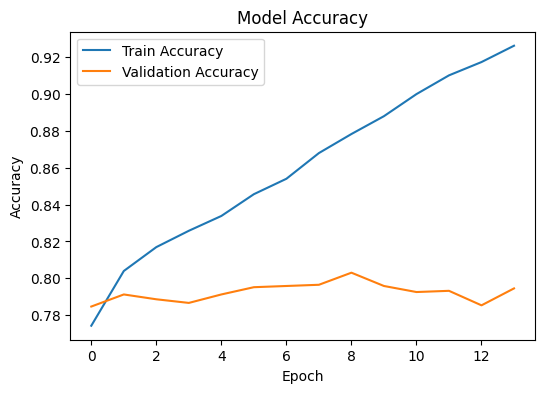

In [59]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**precision:**

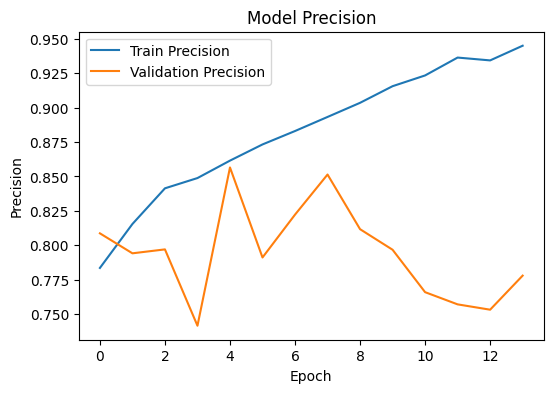

In [60]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**Recall:**

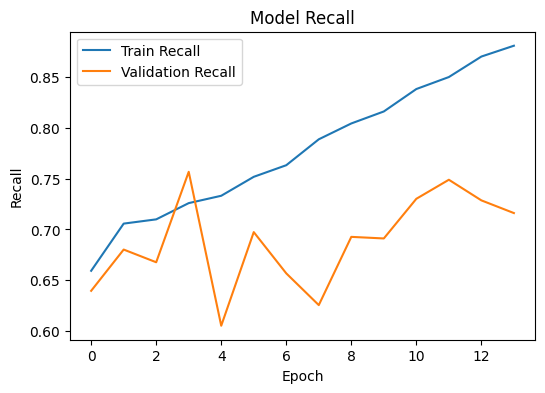

In [61]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

- The model starts overfitting noticeably at epoch 9, with validation performance starting to decline.

- Precision and recall change in opposite directions and fluctuate significantly, indicating that many of the model's predictions are near the threshold.

**Confusion Marix:**

48/48 [==============================] - 0s 4ms/step


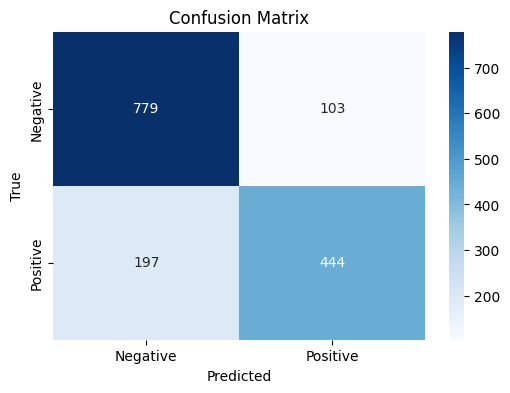

In [62]:
predictions = Bi_LSTM_model.predict(X_val_pad)
predicted_classes = np.where(predictions > 0.5, 1, 0)

conf_matrix = confusion_matrix(y_val, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- Based on the confusion matrix, we can observe a balanced distribution of misclassified samples.

---

### **4.2 Prediction Accuracy**

<div style="text-align:center">
<img src="https://github.com/milanfx/Dataset/blob/main/images/NLP%20Score.png?raw=true" style="width:850px;">
</div>


- The private score is 0.80263, which is similar to the validation score, indicating that the dataset distribution is balanced.

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **5. Project Conclusion**

</div>

---

### **5.1 Model Summary**

1. The difference between traditional XGBoost and neural network LSTM is not significant, indicating that deep learning has advantages on larger datasets rather than small datasets.

2. Hyperparameter tuning can slightly improve model performance, but for better results, larger and more comprehensive datasets are still needed.

3. GloVe can enhance model performance. As large language models (LLMs) continue to develop, similar semantic association models will become increasingly prevalent, aiding humans in uncovering deeper insights and connections in text data.

---

### **5.2 Next Step**

1. To further improve our model, we can enrich the training data by adding more diverse and comprehensive datasets. This can include gathering more data from different sources, performing data augmentation, or integrating external datasets that provide additional context and variability.

2. Another approach is to try attention models such as the Transformer, BERT, or other attention-based architectures.

---